In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
import zipfile, os

# Imports
import warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# **Load Data and Labels**

In [ ]:
base_path = '/content/gb_file/gb_ds'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
path = 'labels.txt'
label = np.array(open(path).read().splitlines())

# **Load Xception Model and Design the Neural Network**

In [ ]:
IMG_SHAPE = (224,224,3)

base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential([
    base_model,
    Conv2D(128, 3, activation='relu'),
    Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    Dense(6, activation='softmax'),
])

# **Train The Model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
              
model.summary()

batch_size = 32
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

class callbackAcc(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.998):
      print('\nReached 99.8% accuracy so cancelling training!')
      self.model.stop_training = True

callbackAcc = callbackAcc()

logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tf_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_generator, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs, 
                    workers=4,
                    validation_data=validation_generator, 
                    validation_steps=validation_steps,
                    )

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 5, 128)         2359424   
_________________________________________________________________
dropout_32 (Dropout)         (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d_27  (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 6)                 774       
Total params: 23,221,678
Trainable params: 2,360,198
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/50
71/71 [==============================] - 17s 240ms/step - loss: 0.8328 - accuracy: 0.692

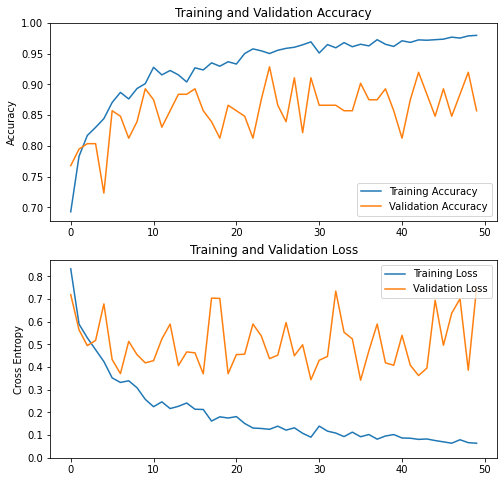

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()